In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
data = pd.read_csv("Perrin Freres monthly champagne sales millions.csv")
data.head()

,Month,Perrin Freres monthly champagne sales millions ?64-?72
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [3]:
data.columns = ["Month", "Sales"]
data.head()

,Month,Sales
0,1964-01,2815.0
1,1964-02,2672.0
2,1964-03,2755.0
3,1964-04,2721.0
4,1964-05,2946.0


In [4]:
data.isna().sum()

Month    1
Sales    2
dtype: int64

In [5]:
data = data.dropna()

In [6]:
data.shape

(105, 2)

In [7]:
data["Month"] = pd.to_datetime(data["Month"])


In [8]:
data.set_index("Month", inplace=True)

In [9]:
data.head()

,Sales
Month,
1964-01-01,2815.0
1964-02-01,2672.0
1964-03-01,2755.0
1964-04-01,2721.0
1964-05-01,2946.0


<Axes: xlabel='Month'>

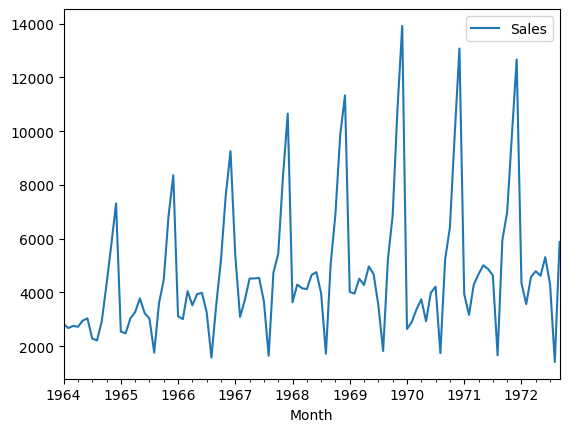

In [10]:
data.plot()

In [11]:
from statsmodels.tsa.seasonal import seasonal_decompose
additive = seasonal_decompose(data["Sales"], model="additive",period=12)
mul = seasonal_decompose(data["Sales"], model="multiplicative",period=12)   


In [12]:
add_df = pd.concat([additive.trend, additive.seasonal, additive.resid, additive.observed], axis=1)
mul_df = pd.concat([mul.trend, mul.seasonal, mul.resid, mul.observed], axis=1)
col = ["trend", "seasonal", "resid", "observed"]
add_df.columns = col
mul_df.columns = col
add_df.head()

,trend,seasonal,resid,observed
Month,,,,
1964-01-01,NaN,-1223.411582,NaN,2815.0
1964-02-01,NaN,-1624.250124,NaN,2672.0
1964-03-01,NaN,-979.229291,NaN,2755.0
1964-04-01,NaN,-850.244916,NaN,2721.0
1964-05-01,NaN,-652.096106,NaN,2946.0


In [13]:
mul_df.head()

,trend,seasonal,resid,observed
Month,,,,
1964-01-01,NaN,0.754627,NaN,2815.0
1964-02-01,NaN,0.674224,NaN,2672.0
1964-03-01,NaN,0.807685,NaN,2755.0
1964-04-01,NaN,0.829951,NaN,2721.0
1964-05-01,NaN,0.874299,NaN,2946.0


In [14]:
from statsmodels.tsa.stattools import adfuller
def adfuller_test(series):
    results = adfuller(series)
    if results[1] <= 0.05:
        print("The data is stationary")
    else:
        print("The data is not stationary")
        

In [15]:
adfuller_test(data["Sales"])

The data is not stationary


In [16]:
# Making the data stationary
data["Sales First Difference"] = data["Sales"] - data["Sales"].shift(1)

In [17]:
adfuller_test(data["Sales First Difference"].dropna())

The data is stationary


<Axes: xlabel='Month'>

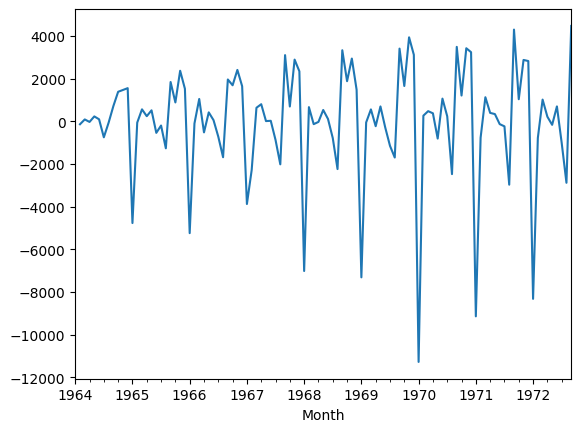

In [18]:
data["Sales First Difference"].plot()

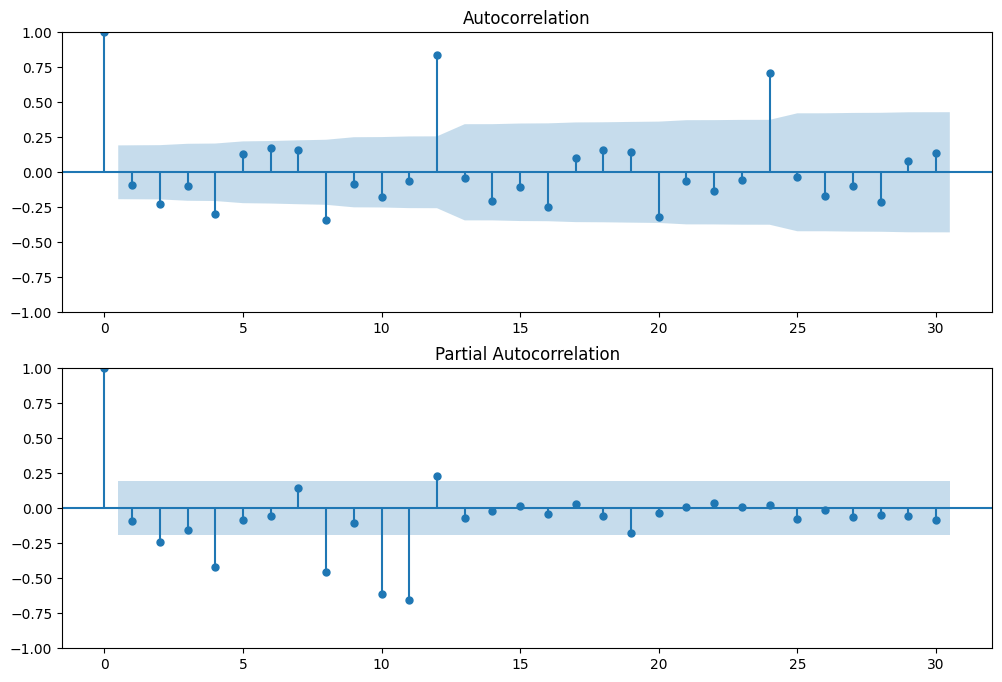

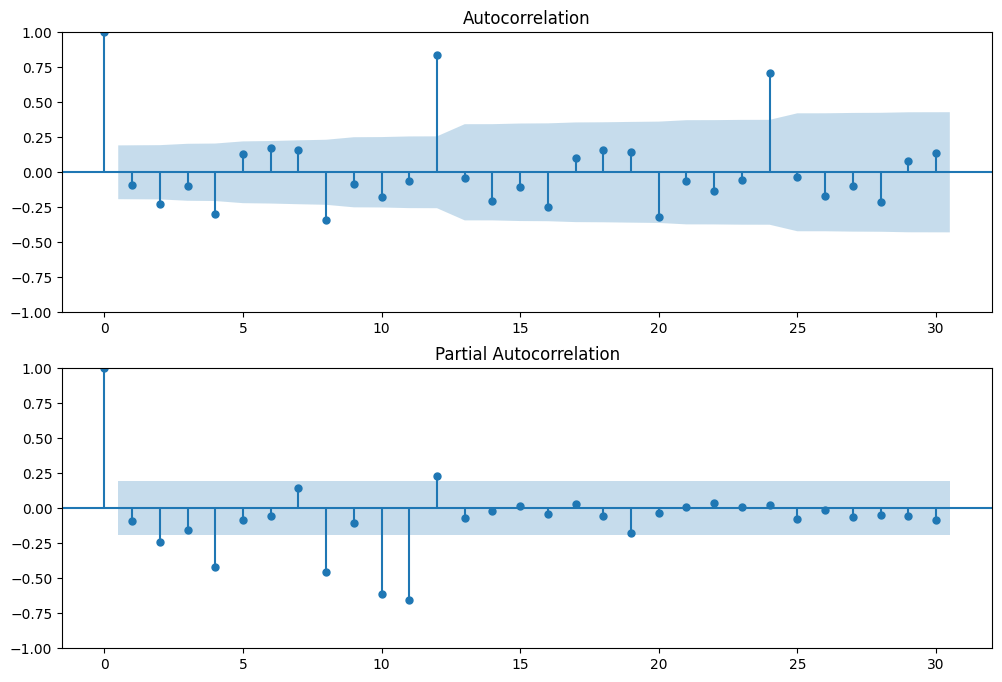

In [19]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
plot_acf(data["Sales First Difference"].dropna(),lags=30,ax=ax1)
ax2 = fig.add_subplot(212)
plot_pacf(data["Sales First Difference"].dropna(),lags=30,ax=ax2)


In [20]:
#p=2,q=2,d=1

from statsmodels.tsa.arima.model import ARIMA
arima = ARIMA(data["Sales"], order=(2,1,2))
model = arima.fit()

/home/varaprasad/miniconda3/envs/llama/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/varaprasad/miniconda3/envs/llama/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/varaprasad/miniconda3/envs/llama/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [21]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  Sales   No. Observations:                  105
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -947.569
Date:                Wed, 29 May 2024   AIC                           1905.139
Time:                        11:23:32   BIC                           1918.361
Sample:                    01-01-1964   HQIC                          1910.495
                         - 09-01-1972                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.2342      0.146     -1.609      0.108      -0.519       0.051
ar.L2          0.1578      0.124      1.273      0.203      -0.085       0.401
ma.L1         -0.1116      0.103     -1.088      0.277      -0.313       0.089
ma.L2         -0.8161      0.115     -7.112      0.000      -1.041      -0.591
sigma2       4.71e+06   6.17e+05      7.633      0.000     3.5e+06    5.92e+06
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):                 1.25
Prob(Q):                              0.95   Prob(JB):                         0.54
Heteroskedasticity (H):               3.49   Skew:                             0.08
Prob(H) (two-sided):                  0.00   Kurtosis:                         3.51
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [22]:
dates = data.index
y_pred = model.predict(typ="levels")


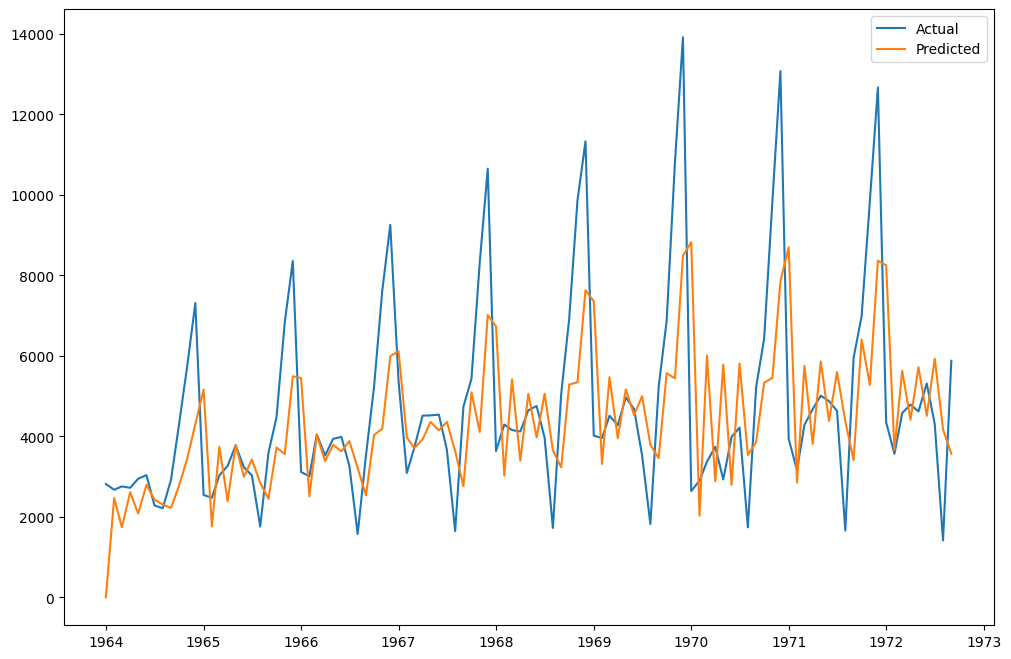

In [23]:
plt.figure(figsize=(12,8))
plt.plot(dates, data["Sales"], label="Actual")
plt.plot(dates, y_pred, label="Predicted")
plt.legend()
plt.show()

In [24]:
# seasonal arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
sarima = SARIMAX(data["Sales"], order=(2,1,2), seasonal_order=(2,1,2,12))
model = sarima.fit()


/home/varaprasad/miniconda3/envs/llama/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/varaprasad/miniconda3/envs/llama/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/home/varaprasad/miniconda3/envs/llama/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/varaprasad/miniconda3/envs/llama/lib/python3.10/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/ho

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            9     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  7.25604D+00    |proj g|=  3.95665D-01

At iterate    5    f=  7.05146D+00    |proj g|=  4.69073D-02

At iterate   10    f=  7.04288D+00    |proj g|=  2.21669D-03

At iterate   15    f=  7.04277D+00    |proj g|=  1.37492D-03

At iterate   20    f=  7.03672D+00    |proj g|=  3.48575D-02

At iterate   25    f=  7.03083D+00    |proj g|=  6.55809D-03

At iterate   30    f=  7.02817D+00    |proj g|=  1.39406D-02

At iterate   35    f=  7.02707D+00    |proj g|=  4.88448D-03

At iterate   40    f=  7.02701D+00    |proj g|=  2.78344D-04

At iterate   45    f=  7.02700D+00    |proj g|=  1.00794D-03

At iterate   50    f=  7.02681D+00    |proj g|=  2.18863D-03

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

/home/varaprasad/miniconda3/envs/llama/lib/python3.10/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


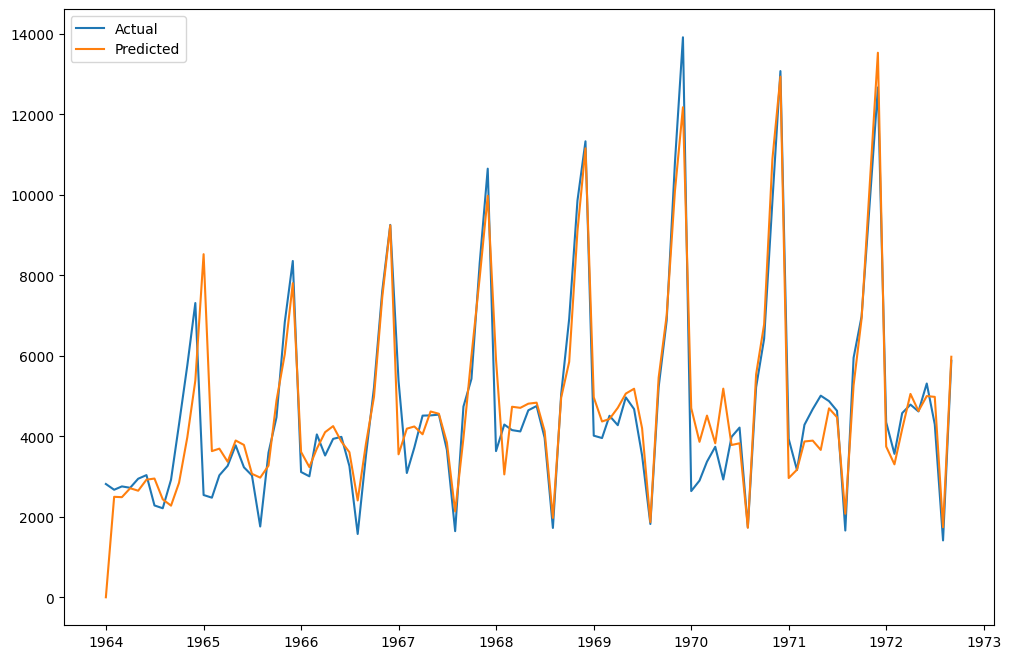

In [25]:
y_pred = model.predict(typ="levels")
plt.figure(figsize=(12,8))
plt.plot(dates, data["Sales"], label="Actual")
plt.plot(dates, y_pred, label="Predicted")
plt.legend()
plt.show()

In [34]:
next_2year = model.forecast(steps=24)
next_2year

1972-10-01     6922.518326
1972-11-01     9839.390514
1972-12-01    12913.163790
1973-01-01     4353.034397
1973-02-01     3887.855927
1973-03-01     4903.936355
1973-04-01     5032.168542
1973-05-01     5195.865589
1973-06-01     5568.517083
1973-07-01     4615.782191
1973-08-01     1610.729146
1973-09-01     6150.059893
1973-10-01     7312.860970
1973-11-01    10090.233181
1973-12-01    12790.125597
1974-01-01     4767.321419
1974-02-01     4091.047307
1974-03-01     5179.045135
1974-04-01     5218.457765
1974-05-01     5276.488890
1974-06-01     5802.987933
1974-07-01     4583.929768
1974-08-01     1774.030711
1974-09-01     6217.726170
Freq: MS, Name: predicted_mean, dtype: float64

In [35]:
data.tail()

,Sales,Sales First Difference
Month,,
1972-05-01,4618.0,-170.0
1972-06-01,5312.0,694.0
1972-07-01,4298.0,-1014.0
1972-08-01,1413.0,-2885.0
1972-09-01,5877.0,4464.0


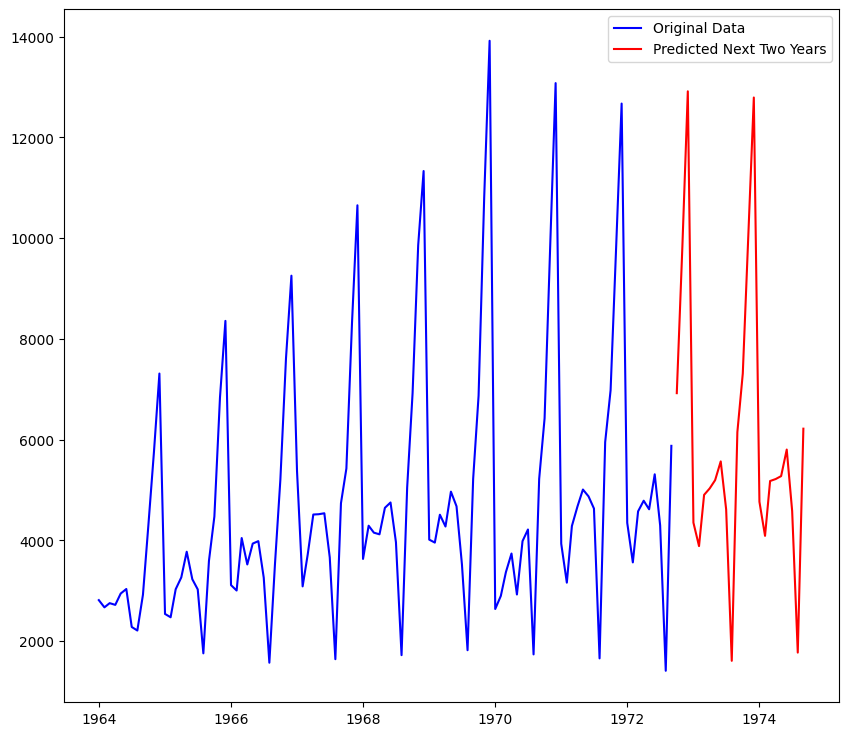

In [36]:
plt.figure(figsize=(10,9))
plt.plot(data["Sales"],label="Original Data",color="blue")
plt.plot(next_2year,label="Predicted Next Two Years", color="red")
plt.legend()
plt.show()